## Notebook Imports

In [84]:
from os import walk
from os.path import join
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import gutenberg

from bs4 import BeautifulSoup
from wordcloud import WordCloud

from PIL import Image

%matplotlib inline

## Constants

In [82]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WHATE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'

# Reading Files

In [3]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

print(type(message))
print(message)

<class 'str'>
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: fro

In [4]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [5]:
stream = open(EXAMPLE_FILE, encoding='utf-8')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)
print(email_body)
#lines



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

## Generater Functions

In [6]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number ** 2

In [7]:
for i in generate_squares(5):
    print(i, end=' - ')

0 - 1 - 4 - 9 - 16 - 

## Email body extraction

In [8]:
def email_body_generator(path):
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            yield file_name, email_body

In [9]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'CATEGORY': classification, 'MESSAGE': email_body})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [10]:
spam_emails = df_from_directory(SPAM_1_PATH, 1)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, 1))
spam_emails.head()

,CATEGORY,MESSAGE
00249.5f45607c1bffe89f60ba1ec9f878039a,1,"Dear Homeowner,\n\n \n\nInterest Rates are at ..."
00373.ebe8670ac56b04125c25100a36ab0510,1,ATTENTION: This is a MUST for ALL Computer Use...
00214.1367039e50dc6b7adb0f2aa8aba83216,1,This is a multi-part message in MIME format.\n...
00210.050ffd105bd4e006771ee63cabc59978,1,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...
00033.9babb58d9298daa2963d4f514193d7d6,1,This is the bottom line. If you can GIVE AWAY...


In [11]:
spam_emails.shape

(1898, 2)

In [12]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails.head()

,CATEGORY,MESSAGE
00769.25bf9a767b5db0ed93f03c1637281663,0,"\n\nIn a message dated 9/24/2002 11:24:58 AM, ..."
01074.8590d61ac0aeeadb58dc2f2ba776c406,0,"Hiya, I always seem to get errors when I do an..."
02479.14365bcad3a60fcf24c5c1813f6291fb,0,\n\nI don't know how one can expect better and...
01417.ce7b07a2114218dbac682b599785820d,0,Tim Peters wrote:\n\n> I've run no experiments...
00357.d559b71616f64ba1d1c1e61a03644fd4,0,"At 10:34 AM -0700 on 8/28/02, Jim Whitehead wr..."


In [13]:
ham_emails.shape

(3901, 2)

In [14]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire dataframe is ', data.shape)
data.head()

Shape of entire dataframe is  (5799, 2)


,CATEGORY,MESSAGE
00249.5f45607c1bffe89f60ba1ec9f878039a,1,"Dear Homeowner,\n\n \n\nInterest Rates are at ..."
00373.ebe8670ac56b04125c25100a36ab0510,1,ATTENTION: This is a MUST for ALL Computer Use...
00214.1367039e50dc6b7adb0f2aa8aba83216,1,This is a multi-part message in MIME format.\n...
00210.050ffd105bd4e006771ee63cabc59978,1,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...
00033.9babb58d9298daa2963d4f514193d7d6,1,This is the bottom line. If you can GIVE AWAY...


In [15]:
data.tail()

,CATEGORY,MESSAGE
00609.dd49926ce94a1ea328cce9b62825bc97,0,"I'm one of the 30,000 but it's not working ver..."
00957.e0b56b117f3ec5f85e432a9d2a47801f,0,Damien Morton quoted:\n\n>W3C approves HTML 4 ...
01127.841233b48eceb74a825417d8d918abf8,0,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\..."
01178.5c977dff972cd6eef64d4173b90307f0,0,"Once upon a time, Manfred wrote :\n\n\n\n> I w..."
00747.352d424267d36975a7b40b85ffd0885e,0,"If you run Pick, and then use the ""New FTOC"" b..."


## Data Cleaning: Checking for missing values

In [16]:
# Check if any message bodies are null

data['MESSAGE'].isnull().values.any()

False

In [17]:
type("")
len("")

0

In [18]:
my_var = None
type(my_var)

NoneType

In [19]:
# Check if there are empty emails. (String length zero)
(data.MESSAGE.str.len() == 0).any()

True

In [20]:
(data.MESSAGE.str.len() == 0).sum()

4

In [21]:
# Challange checking how many null values.

#(data.MESSAGE.str.len() == None).any()
data['MESSAGE'].isnull().sum()

0

## Locating empty emails

In [22]:
type(data.MESSAGE.str.len() == 0)

pandas.core.series.Series

In [23]:
data[data.MESSAGE.str.len()==0].index

Index(['cmds', 'cmds', '.DS_Store', 'cmds'], dtype='object')

In [24]:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

## Remove System File Entries from DataFrame

In [25]:
#data = data.drop(['cmds'])
#Same thing
data.drop(['cmds'], inplace=True)

In [26]:
data.shape

(5796, 2)

In [27]:
data[data.MESSAGE.str.len()==0].index

Index(['.DS_Store'], dtype='object')

## Add documetn IDs to Track emails in Dataset

In [28]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [29]:
data.DOC_ID

00249.5f45607c1bffe89f60ba1ec9f878039a       0
00373.ebe8670ac56b04125c25100a36ab0510       1
00214.1367039e50dc6b7adb0f2aa8aba83216       2
00210.050ffd105bd4e006771ee63cabc59978       3
00033.9babb58d9298daa2963d4f514193d7d6       4
                                          ... 
00609.dd49926ce94a1ea328cce9b62825bc97    5791
00957.e0b56b117f3ec5f85e432a9d2a47801f    5792
01127.841233b48eceb74a825417d8d918abf8    5793
01178.5c977dff972cd6eef64d4173b90307f0    5794
00747.352d424267d36975a7b40b85ffd0885e    5795
Name: DOC_ID, Length: 5796, dtype: int64

In [30]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
0,1,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",00249.5f45607c1bffe89f60ba1ec9f878039a
1,1,ATTENTION: This is a MUST for ALL Computer Use...,00373.ebe8670ac56b04125c25100a36ab0510
2,1,This is a multi-part message in MIME format.\n...,00214.1367039e50dc6b7adb0f2aa8aba83216
3,1,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,00210.050ffd105bd4e006771ee63cabc59978
4,1,This is the bottom line. If you can GIVE AWAY...,00033.9babb58d9298daa2963d4f514193d7d6


In [31]:
data.tail()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
5791,0,"I'm one of the 30,000 but it's not working ver...",00609.dd49926ce94a1ea328cce9b62825bc97
5792,0,Damien Morton quoted:\n\n>W3C approves HTML 4 ...,00957.e0b56b117f3ec5f85e432a9d2a47801f
5793,0,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\...",01127.841233b48eceb74a825417d8d918abf8
5794,0,"Once upon a time, Manfred wrote :\n\n\n\n> I w...",01178.5c977dff972cd6eef64d4173b90307f0
5795,0,"If you run Pick, and then use the ""New FTOC"" b...",00747.352d424267d36975a7b40b85ffd0885e


## Save to File using Pandas

In [32]:
data.to_json(DATA_JSON_FILE)

## Number of Spam Messages Visualised (Pie Charts)

In [33]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [34]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

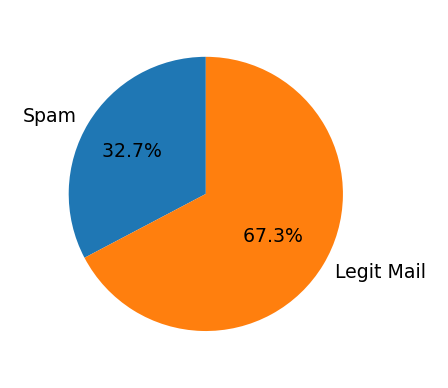

In [35]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, autopct='%1.1f%% ')
plt.show()

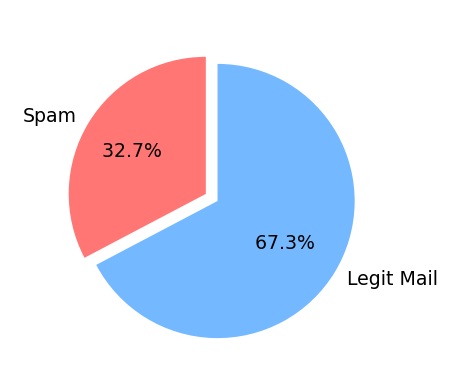

In [36]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#ff7675','#74b9ff']

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, autopct='%1.1f%% ', colors=custom_colours, explode=[0, 0.1])
plt.show()

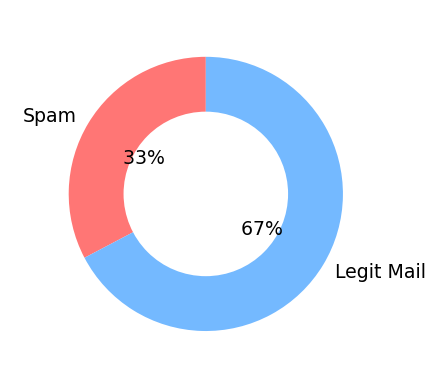

In [37]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#ff7675','#74b9ff']

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, autopct='%1.0f%% ', colors=custom_colours, pctdistance=0.5)

#draw circle

centre_circle = plt.Circle((0,0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

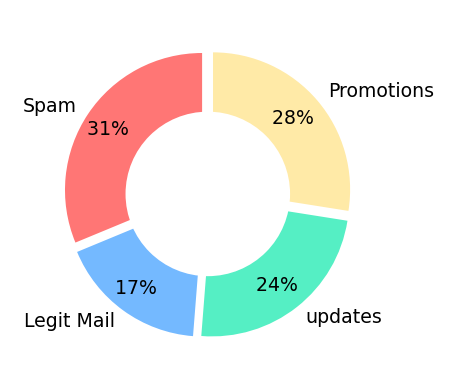

In [38]:
category_names = ['Spam', 'Legit Mail', 'updates', 'Promotions']
sizes = [25,14,19,22]
custom_colours = ['#ff7675','#74b9ff', '#55efc4', '#ffeaa7']
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, autopct='%1.0f%% ', colors=custom_colours, pctdistance=0.8, explode=offset)

#draw circle

centre_circle = plt.Circle((0,0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

### Natural Language Processing

### Text Pre-Processing

In [39]:
#Convert to lower case
msg = 'All work an no play makes Jack a dull boy.'
msg.lower()

'all work an no play makes jack a dull boy.'

### Download the NLTK Resources (Tokenizer & Stopwords)

In [40]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/abdul/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [41]:
nltk.download('stopwords')
nltk.download('shakespeare')
nltk.download('corpus')
nltk.download('gutenberg')

[nltk_data] Downloading package stopwords to /Users/abdul/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     /Users/abdul/nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!
[nltk_data] Error loading corpus: Package 'corpus' not found in index
[nltk_data] Downloading package gutenberg to /Users/abdul/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

## Tokenizing

In [42]:
msg = 'All work an no play makes Jack a dull boy.'
word_tokenize(msg.lower())

['all', 'work', 'an', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

## Removing Stop Words

In [43]:
stop_words = set(stopwords.words('english'))

In [44]:
type(stop_words)

set

In [45]:
if 'this' in stop_words: print('Found it!')

Found it!


In [46]:
#Challange: print out 'Nope. Not in here'

In [47]:
if 'hello' not in stop_words: print('Nope. Not in here')

Nope. Not in here


In [48]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be.'
words = word_tokenize(msg.lower())

filtered_words = []
for word in words:
    if word not in stop_words:
        filtered_words.append(word)
        
print(filtered_words)

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']


## Word Stems

In [49]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. \
Nobody expects the spanish inquisition'
words = word_tokenize(msg.lower())


#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')

filtered_words = []
for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
        
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inquisit']


## Removing punctuation

In [50]:
'pmnj'.isalpha()

True

In [51]:
'p?j'.isalpha()

False

In [52]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be.??? \
Nobody expects the spanish inquisition'
words = word_tokenize(msg.lower())


#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')

filtered_words = []
for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
        
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


## Removing HTML tags from Emails

In [53]:
soup = BeautifulSoup(data.at[2,'MESSAGE'], 'html.parser')
print(soup.prettify)

<bound method Tag.prettify of This is a multi-part message in MIME format.



------=_NextPart_000_1CDC19_01C25366.4B57F3A0

Content-Type: text/plain;

	charset="Windows-1252"

Content-Transfer-Encoding: quoted-printable



 We dare you...

 Try to find a better annuity!

=20

  - 5.40% Guaranteed for 6 Years=0A=

- 6 Year Surrender Charge=0A=

- 5% Agent

Commission up to age 80=09

Call today for more information!

 800-888-7641 ext. 103

- or -



Please fill out the form below for more information	=20

Name:	 	  =09

E-mail:	 	=20

Phone:	 	=20

City:	 	 State:	 	=20

 	    =09

=20

 PMG Financial Services

*5.40% for deposits of $100,000 and up, 5.25% interest for deposits

totalling $25,000-$99,999.	=20

We don't want anyone to receive our mailings who does not wish to

receive them. This is a professional communication sent to insurance

professionals. To be removed from this mailing list, DO NOT REPLY to

this message. Instead, go here: http://www.insuranceiq.com/optout

<http

In [54]:
soup.get_text()

'This is a multi-part message in MIME format.\n\n\n\n------=_NextPart_000_1CDC19_01C25366.4B57F3A0\n\nContent-Type: text/plain;\n\n\tcharset="Windows-1252"\n\nContent-Transfer-Encoding: quoted-printable\n\n\n\n We dare you...\n\n Try to find a better annuity!\n\n=20\n\n  - 5.40% Guaranteed for 6 Years=0A=\n\n- 6 Year Surrender Charge=0A=\n\n- 5% Agent\n\nCommission up to age 80=09\n\nCall today for more information!\n\n 800-888-7641 ext. 103\n\n- or -\n\n\n\nPlease fill out the form below for more information\t=20\n\nName:\t \t  =09\n\nE-mail:\t \t=20\n\nPhone:\t \t=20\n\nCity:\t \t State:\t \t=20\n\n \t    =09\n\n=20\n\n PMG Financial Services\n\n*5.40% for deposits of $100,000 and up, 5.25% interest for deposits\n\ntotalling $25,000-$99,999.\t=20\n\nWe don\'t want anyone to receive our mailings who does not wish to\n\nreceive them. This is a professional communication sent to insurance\n\nprofessionals. To be removed from this mailing list, DO NOT REPLY to\n\nthis message. Instead, g

## Functions for Email Processing

In [55]:
def clean_message(message, stemmer=PorterStemmer(),
                  stop_words=set(stopwords.words('english'))):
    
    # Converts to lower case and splits up the words
    words = word_tokenize(message.lower())
    filtered_words = []
    
    for word in words:
        # Remove the stop words and punctuation.
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [56]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

## Apply Cleaning and Tokenisation to all messages

### Slicing Dataframes and Series & Creating Subsets

In [57]:
data.iat[2, 2]

'00214.1367039e50dc6b7adb0f2aa8aba83216'

In [58]:
first_emails = data.MESSAGE.iloc[0:3]
nested_list = first_emails.apply(clean_message)

In [59]:
# flat_list = []
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)
        
flat_list = [item for sublist in nested_list for item in sublist]    
    
len(flat_list)

390

In [60]:
%%time

#use apply() on all messages in the dataframe
nested_list = data.MESSAGE.apply(clean_message)

CPU times: user 26.2 s, sys: 124 ms, total: 26.4 s
Wall time: 26.4 s


In [61]:
nested_list.head()

DOC_ID
0    [dear, homeown, interest, rate, lowest, point,...
1    [attent, must, comput, user, packag, deal, nor...
2    [messag, mime, format, dare, tri, find, better...
3    [import, inform, new, domain, name, final, ava...
4    [bottom, line, give, away, cd, free, peopl, li...
Name: MESSAGE, dtype: object

### Using Logic to Slice Dataframes

In [62]:
data[data.CATEGORY == 1].shape

(1896, 3)

In [63]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

### Subsetting a Series with an index

In [64]:
type(doc_ids_ham)

pandas.core.indexes.numeric.Int64Index

In [65]:
type(nested_list)

pandas.core.series.Series

In [66]:
nested_list_ham = nested_list.loc[doc_ids_ham]

In [67]:
nested_list_ham.shape

(3900,)

In [68]:
nested_list_ham.tail()

DOC_ID
5791    [one, work, well, week, te, updat, server, syn...
5792    [damien, morton, quot, approv, html, abl, say,...
5793    [mon, che, wrote, that, correct, line, ad, rep...
5794    [upon, time, manfr, wrote, would, like, instal...
5795    [run, pick, use, new, ftoc, button, show, mess...
Name: MESSAGE, dtype: object

In [69]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [70]:
###
### Challanges

In [71]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham)
# To Find unique use value_count
normal_words = pd.Series(flat_list_ham).value_counts()
normal_words.shape[0]

20971

In [72]:
normal_words[:10]

http      7959
use       3638
list      2888
one       2379
get       2288
mail      2259
would     2005
like      1932
messag    1857
work      1800
dtype: int64

In [73]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam)
# To Find unique use value_count
spammy_words = pd.Series(flat_list_spam).value_counts()
spammy_words.shape[0]

13945

In [74]:
spammy_words[:10]

font      20520
br        19865
nbsp      11254
http      10715
td        10654
b          7447
p          7239
arial      6631
tr         6365
center     4724
dtype: int64

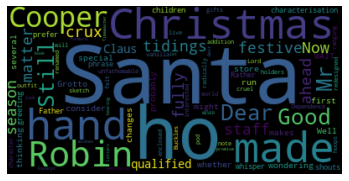

In [75]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [76]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

In [77]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [78]:
example_corpus

['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', ...]

In [79]:
word_list1 = [''.join(word) for word in example_corpus]
novel_as_string = ''.join(word_list1)

In [80]:
#word_list1
novel_as_string

'[MobyDickbyHermanMelville1851]ETYMOLOGY.(SuppliedbyaLateConsumptiveUshertoaGrammarSchool)ThepaleUsher--threadbareincoat,heart,body,andbrain;Iseehimnow.Hewaseverdustinghisoldlexiconsandgrammars,withaqueerhandkerchief,mockinglyembellishedwithallthegayflagsofalltheknownnationsoftheworld.Helovedtodusthisoldgrammars;itsomehowmildlyremindedhimofhismortality."Whileyoutakeinhandtoschoolothers,andtoteachthembywhatnameawhale-fishistobecalledinourtongueleavingout,throughignorance,theletterH,whichalmostalonemakeththesignificationoftheword,youdeliverthatwhichisnottrue."--HACKLUYT"WHALE....Sw.andDan.HVAL.Thisanimalisnamedfromroundnessorrolling;forinDan.HVALTisarchedorvaulted."--WEBSTER\'SDICTIONARY"WHALE....ItismoreimmediatelyfromtheDut.andGer.WALLEN;A.S.WALW-IAN,toroll,towallow."--RICHARDSON\'SDICTIONARYKETOS,GREEK.CETUS,LATIN.WHOEL,ANGLO-SAXON.HVALT,DANISH.WAL,DUTCH.HWAL,SWEDISH.WHALE,ICELANDIC.WHALE,ENGLISH.BALEINE,FRENCH.BALLENA,SPANISH.PEKEE-NUEE-NUEE,FEGEE.PEKEE-NUEE-NUEE,ERROMANGOAN.EXTRACTS

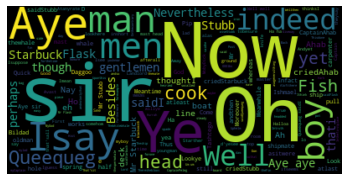

In [87]:
icon = Image.open(WHATE_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)

word_cloud = WordCloud().generate(novel_as_string)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()